# Simple Detection Evaluation 

### Leval 1. Binary Evaluation - Species Present vs Not-Present in image
**Evaluating the performance of object detector on classifying task, i.e - performance on finding the species in images**

1. Overall Level
2. Species level

### Level 2. Species Count 
1. Overall level
2. Speceis level
3. Count level

### Level 3. Incorporate IoU
[Look at this when writing](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

## Level 1: Overall Level
1. Filter out the images that were not user for model training
2. Make predictions on these images
    - wait, we can run the predictions on all the image and then do the step 1
3. Run the queries - predictorExtractor_main.py and prediction_groundtruth_consolidation_main.py
4. Evaluate predictions

In [103]:
# importing the necessary librabies
import csv, glob, sys
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/')
import data_prep.csv_shards_consolidation as csc
import data_prep.data_prep_utils as dataprep_utils

pd.options.display.max_columns=50

In [4]:
# Defining variabled
round_number = 'round1_ckpt69k' # round2_ckpt56960, round1_ckpt69k
round_number_base_files = 'round2'
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

In [5]:
df_pred_gt_consolidated = csc.combine_pred_groundtruth_consolidated_files(filepath_list)
print(df_pred_gt_consolidated.shape)
print(df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].shape) # Ground Truth Counts
df_pred_gt_consolidated.tail()

(187686, 5)
(142745, 5)


,filename,species,labels,groundtruth_counts,prediction_counts
187681,S10/T11/T11_R2/S10_T11_R2_IMAG0335,zebra,5,NaN,1
187682,S10/T11/T11_R2/S10_T11_R2_IMAG1101,elephant,11,NaN,1
187683,S10/T11/T11_R2/S10_T11_R2_IMAG1113,elephant,11,NaN,1
187684,S10/T11/T11_R2/S10_T11_R2_IMAG1260,dikDik,4,NaN,1
187685,S10/T11/T11_R2/S10_T11_R2_IMAG1323,buffalo,14,NaN,1


### Level 1: Overall level

# Level 1. Species level

In [4]:
y_true = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["groundtruth_counts"]]
y_pred = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["prediction_counts"]]
print(sum(y_true), sum(y_pred))

tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
print(metric.confusion_matrix(y_true, y_pred))
print(tn, fp, fn, tp)

# For a classification task the recall is:
recall = round(tp/(tp + fn), 3) # Correct
precision = round(tp/(tp + fp), 3)
accuracy = round((tp)/(tp + fn), 3)
f1_score = round(2*recall*precision/(recall + precision), 3)

print("Recall: {0}".format(recall))
print("Precision: {0}".format(precision))
print("F1-Score: {0}".format(f1_score))
print("Accuracy: {0}".format(accuracy))
      

141224 185409
[[     0  62379]
 [ 18194 123030]]
0 62379 18194 123030
Recall: 0.871
Precision: 0.664
F1-Score: 0.754
Accuracy: 0.871


Confusion matrix, without normalization
[[     0  62379]
 [ 18194 123030]]


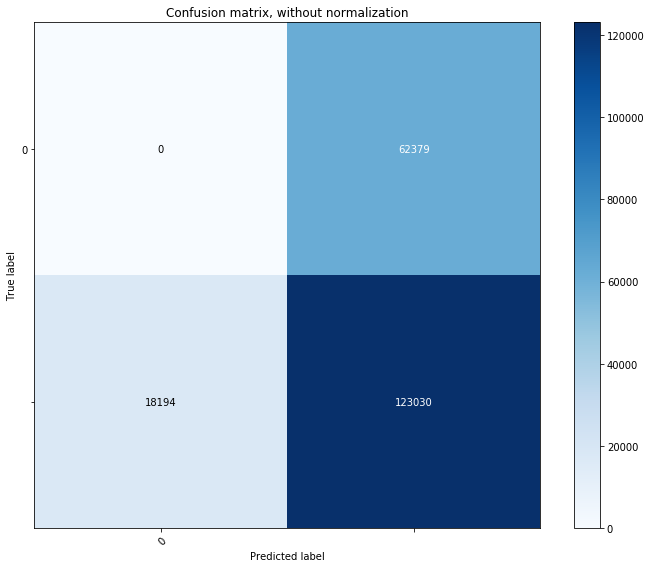

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          round_number,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metric.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('./Dashboard/Species_level_overall_confusion_matrix_{0}.jpg'.format(round_number))
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, round_number = round_number, classes=np.array(['1', '0']),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes=np.array(['false', 'true']), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


# Writing the callable function

**Evaluating the level performance for (Recall vs Precision) vs Size**

In [7]:
round_number = 'round0'

In [8]:
# Gather all the dataset on which to perform the evaluation
import sys, glob
import pandas as pd
# import sklearn.metrics as metric

sys.path.append('./')
import model_evaluation_metrics as mem

filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

df_pred_gt_consolidated = csc.combine_pred_groundtruth_consolidated_files(filepath_list)
## ------------------------------ ##
# 1.a - overall performance
## ------------------------------ ##
accuracy = mem.get_binary_classifcation_overall_perfomance(df_pred_gt_consolidated)

## ------------------------------ ##
# 1.b - Species Level
## ------------------------------ ##
multi_class_confusion_matrix = mem.get_binary_classifcation_species_level_perfomance(df_pred_gt_consolidated)
species_level_performance_binary_df = pd.DataFrame(multi_class_confusion_matrix).transpose().reset_index()
# species_level_performance_binary_df.to_csv('species_level_performance_binary_df.csv', index=False)
species_level_performance_binary_df['Precision'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FP'])
species_level_performance_binary_df['Recall'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])
species_level_performance_binary_df['Accuracy'] = \
     species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])

#### Create a Dataframe with Species to Training Data distribution for the model being evaluated
metric_temp = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/bootstrap_LowerBound50p/Training_data_{0}.csv'.format(round_number_base_files)

df_temp_gt = pd.read_csv(metric_temp)
df_temp_gt = df_temp_gt[['Species', 'Training_Data_Size', 'Training_Data_freq_normalized']]
# df_temp_gt.head()
#### Creating a DataFrame with Species distribution in the Test Dataset
df_temp_pred = df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].groupby(by=['species'], as_index=False)['filename'].count()
df_temp_pred.columns = ['species', 'Test_Data_Size']
df_temp_pred['Test_Data_freq_normalized'] = df_temp_pred['Test_Data_Size']/sum(df_temp_pred['Test_Data_Size'])

#### Merging the frequency for distributions for trainig and ground truth!
df_distribution_gt_pred = pd.merge(left=df_temp_gt,
                                   right=df_temp_pred,
                                   left_on=df_temp_gt['Species'],
                                   right_on=df_temp_pred['species'],
                                   how='left'
                                  )
df_distribution_gt_pred = df_distribution_gt_pred.drop(columns=['key_0', 'species'])
df_distribution_gt_pred['GT_TD_diff'] = \
                    df_distribution_gt_pred.Training_Data_freq_normalized/df_distribution_gt_pred.Test_Data_freq_normalized
df_distribution_gt_pred.head()

#### Merging the Distribution data for Groundtruth and Predictions into the species level performance metric
species_level_performance_binary_df = pd.merge(left=species_level_performance_binary_df,
                                               right=df_distribution_gt_pred,
                                               left_on=species_level_performance_binary_df['index'],
                                               right_on=df_distribution_gt_pred['Species'],
                                               how='left'
                                              )
species_level_performance_binary_df = species_level_performance_binary_df.drop(columns=['key_0', 'index'])

The overall accuracy in classification: 0.604
The overall precision in classification: 0.604
Level 1: Species Level Overall
Recall: 0.871
Precision: 0.664
F1-Score: 0.754
Accuracy: 0.871


**Plot Performance**

In [9]:
species_level_performance_binary_df.head(n=5)

,FN,FP,TN,TP,Precision,Recall,Accuracy,Species,Training_Data_Size,Training_Data_freq_normalized,Test_Data_Size,Test_Data_freq_normalized,GT_TD_diff
0,7,45,0,63,0.583333,0.900000,0.900000,aardvark,394,0.001654,70.0,0.000496,3.336731
1,14,14,0,38,0.730769,0.730769,0.730769,aardwolf,236,0.000991,52.0,0.000368,2.690492
2,99,247,0,502,0.670227,0.835275,0.835275,baboon,1708,0.007170,601.0,0.004256,1.684754
3,11,88,0,45,0.338346,0.803571,0.803571,batEaredFox,467,0.001960,56.0,0.000397,4.943697
4,690,7919,0,3833,0.326157,0.847446,0.847446,buffalo,10840,0.045503,4523.0,0.032027,1.420776


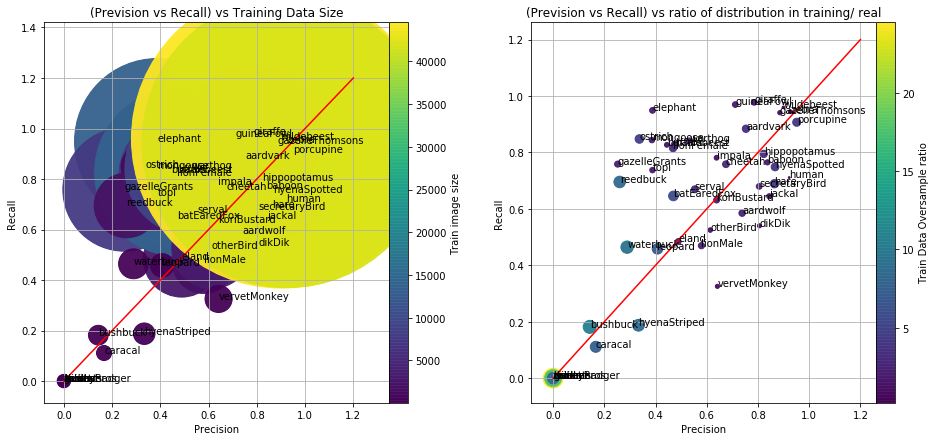

In [99]:
import matplotlib.pyplot as plt

# species_performance_metric = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/metric_temp.csv'

# df_vis = pd.read_csv(species_performance_metric)
df_vis = species_level_performance_binary_df
df_vis = df_vis.fillna(0)
x = df_vis['Precision']
y = df_vis['Recall']

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
#######################################
# Plot for precision vs recall for training data size
im1 = ax1.scatter(x, y, c=df_vis['Training_Data_Size'],\
            s=2*df_vis['Training_Data_Size'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax1.annotate(txt, (x[i], y[i]))
ax1.set_title('(Prevision vs Recall) vs Training Data Size')
ax1.set_xlabel('Precision')
ax1.set_ylabel('Recall')

cbar1 = fig.colorbar(im1, ax=ax1, pad=0)
cbar1.set_label('Train image size')

ax1.grid()
ax1.plot([0, 1.2], [0, 1.2], 'r-')


#######################################
# Plot of Precision vs recall for oversampling ratio
im2 = ax2.scatter(x, y, c=df_vis['GT_TD_diff'],\
            s=16*df_vis['GT_TD_diff'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax2.annotate(txt, (x[i], y[i]))
ax2.set_title('(Prevision vs Recall) vs ratio of distribution in training/ real')
ax2.set_xlabel('Precision')
ax2.set_ylabel('Recall')

# fig.colorbar(im2)
cbar2 = fig.colorbar(im2, ax=ax2, pad=0)
cbar2.set_label('Train Data Oversample ratio')


ax2.grid()
ax2.plot([0, 1.2], [0, 1.2], 'r-')

# Save the figure to the disk
fig.savefig('./Dashboard/Precision_Recall_{0}.jpg'.format(round_number))

In [10]:
species_level_performance_binary_df.to_csv('bootstrap_LowerBound50p/{0}_SS_s10_performance_level_1b.csv'.format(round_number), index=False)

# Level 2: Count
Given the model predicted the correct species, how good it is in the count.
1. **Absolute count per image** - # of animals in ground truth vs # of animals in predictions 
2. **Count per image-species** - # of animals in ground truth vs # of animals in predictions 
3. **Precision and Recall**

In [10]:
# Add parameters
k = 6
print(df_pred_gt_consolidated.shape)
df_pred_gt_consolidated.head(n=2)

(203603, 5)


,filename,species,labels,groundtruth_counts,prediction_counts
0,S10/F03/F03_R2/S10_F03_R2_IMAG0001,human,1,1,1
1,S10/F05/F05_R2/S10_F05_R2_IMAG0052,human,1,1,NaN


In [11]:
# 1.
def get_count_level_performance(df_pred_gt_consolidated, level):
    """Level could be 'overall' or 'species'. The species is a particular species.
    """
    print(level)
    # Absolute Count per image
    df_pred_gt_consolidated_inter = df_pred_gt_consolidated.fillna(0)
    if level!="Overall":
        df_pred_gt_consolidated_inter = df_pred_gt_consolidated_inter[(df_pred_gt_consolidated_inter['species']==level) \
                                                                      & (df_pred_gt_consolidated_inter['groundtruth_counts']!=0)]
        
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    # converting values to integer
    df_pred_gt_consolidated_inter['groundtruth_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['prediction_counts']]


    # Grouping the animal counts by image
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_inter.groupby(by='filename', as_index=False) \
                ['groundtruth_counts', 'prediction_counts'].sum()
    # ignore all cases with 0 groundtruth or prediction counts
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_count[(df_pred_gt_consolidated_count['prediction_counts']!=0) \
                                                                      | (df_pred_gt_consolidated_count['groundtruth_counts']!=0)]

    df_pred_gt_consolidated_count['df_gt_pred'] = df_pred_gt_consolidated_count.groundtruth_counts - \
                                                        df_pred_gt_consolidated_count.prediction_counts
    df_pred_gt_consolidated_count['df_df_pred_abs'] = [abs(val) for val in df_pred_gt_consolidated_count['df_gt_pred']]

    # calculating correctness in +/- k variance of the groundtruth count
    total_image = len(set(df_pred_gt_consolidated_count.filename))
    
    if total_image == 0:
        return "Divide By Zero"
    accyracy_for_k_round = [round(df_pred_gt_consolidated_count[df_pred_gt_consolidated_count.df_df_pred_abs<=i].shape[0]/total_image, 5) \
                            for i in range(k)]

    for i in range(k):
        print("Accuray with {1} variance: {0}".format(accyracy_for_k_round[i], i))

    # plot bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(k), accyracy_for_k_round)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Deviation')
    ax.set_ylabel('Accuracy')
    ax.set_title('Count Accuracy at different deviation on difference in gt vs prediction: {0}'.format(level))
    ax.grid()
    # Save the figure to the disk
    fig.savefig('./Dashboard/Accuracy_at_variance_bar_{1}_{0}.jpg'.format(round_number, level))
    
    return df_pred_gt_consolidated_count

Overall
Accuray with 0 variance: 0.44617
Accuray with 1 variance: 0.65605
Accuray with 2 variance: 0.73944
Accuray with 3 variance: 0.79032
Accuray with 4 variance: 0.82991
Accuray with 5 variance: 0.86205


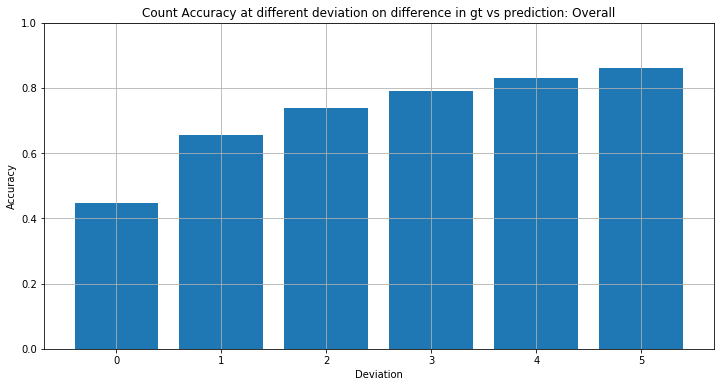

In [12]:
# Plot the overall level performance on count
df_pred_gt_consolidated_count = get_count_level_performance(df_pred_gt_consolidated, "Overall")

# Plot the species level performance on count
# for species in set(df_pred_gt_consolidated.species):
#     get_count_level_performance(df_pred_gt_consolidated, species)

In [13]:
df_pred_gt_consolidated_count.head()
# df_pred_gt_consolidated_inter = df_pred_gt_consolidated.fillna(0)
# df_pred_gt_consolidated_inter['groundtruth_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
# df_pred_gt_consolidated_inter['groundtruth_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
# df_pred_gt_consolidated_inter['prediction_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
# df_pred_gt_consolidated_inter['prediction_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
# # converting values to integer
# df_pred_gt_consolidated_inter['groundtruth_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
# df_pred_gt_consolidated_inter['prediction_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['prediction_counts']]


# df_pred_gt_consolidated_count = df_pred_gt_consolidated_inter.groupby(by='filename', as_index=False) \
#                 ['groundtruth_counts', 'prediction_counts'].sum()

# set(df_pred_gt_consolidated_count.prediction_counts)

,filename,groundtruth_counts,prediction_counts,df_gt_pred,df_df_pred_abs
0,S10/B03/B03_R1/S10_B03_R1_IMAG0005,1,1,0,0
1,S10/B03/B03_R1/S10_B03_R1_IMAG0006,1,1,0,0
2,S10/B03/B03_R1/S10_B03_R1_IMAG0007,1,1,0,0
3,S10/B03/B03_R1/S10_B03_R1_IMAG0106,1,1,0,0
4,S10/B03/B03_R1/S10_B03_R1_IMAG0107,1,1,0,0


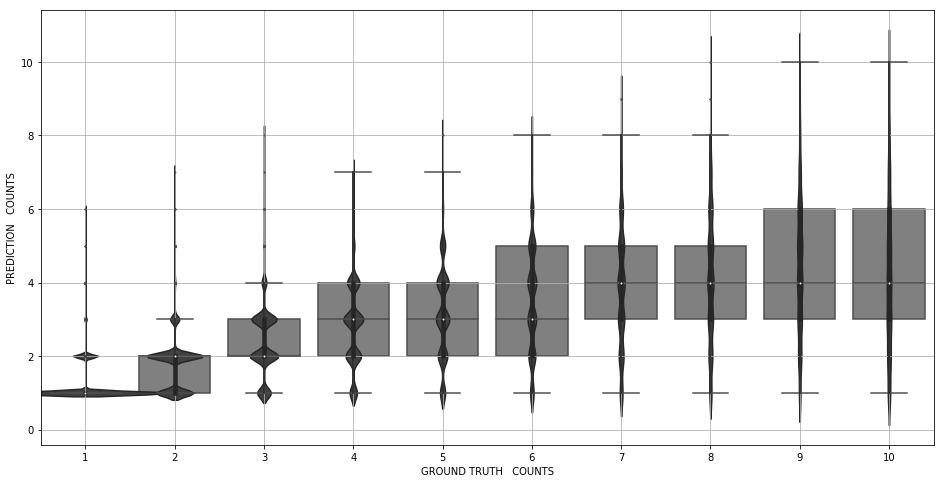

In [14]:
df_pred_gt_consolidated_count_temp = df_pred_gt_consolidated_count[df_pred_gt_consolidated_count['groundtruth_counts']<=10] 
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_gt_consolidated_count_temp, 
                 color="grey",
                 saturation=0.1,
#                  hue="smoker",
                 fliersize=1
                )
ax = sns.violinplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_gt_consolidated_count_temp, 
                 width=2, 
                 color='0.25'
                )

ax.set(xlabel='GROUND TRUTH   COUNTS', ylabel='PREDICTION   COUNTS')
plt.grid()

plt.savefig('./Dashboard/Count_level_boxplot_{0}.jpg'.format(round_number))

### Predictions below area-threshold analysis
**For paper**

In [149]:
# Defining variable
import bootstrapping.prediction_groundtruth_consolidation as pgc
round_number = 'round2_ckpt56960' # round2_ckpt56960, round1_ckpt69k
# round_number_base_files = 'round2'
box_threshold = 96100 # 44100 , 176400, 90000, 67600, 96100, 94840 
species = 'buffalo' # 'zebra', 'wildebeest', 'hartebeest', 'gazelleThomsons', 'buffalo', 'Overall'
# Predictions
box_filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/msi_test_image_list_s10-*".format(round_number))
# Ground Truth
groundtruth_csv_path = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/SER_S10_data_nonEmpty.csv'

In [150]:
df_box = csc.combine_tfr_decoded_predictions(box_filepath_list).dropna()
df_box.shape # 355801

(334873, 7)

In [151]:
## Predictions preprocessing ##
df_box = csc.combine_tfr_decoded_predictions(box_filepath_list).dropna()

df_box['xmin_o'] = df_box['xmin']*1000 # _o for original size
df_box['xmax_o'] = df_box['xmax']*1000
df_box['ymin_o'] = df_box['ymin']*750
df_box['ymax_o'] = df_box['ymax']*750
df_box['box_width'] = df_box['xmax_o'] - df_box['xmin_o']
df_box['box_height'] = df_box['ymax_o'] - df_box['ymin_o']
df_box['area'] = df_box['box_width']*df_box['box_height']

## Ground Truth animal counts ##
groundtruth_df_img = pgc.process_grondtruth_classification_data(groundtruth_csv_path, label_map_df)

# filter single species images for the given species only
if species != 'Overall':
    df_one_species = groundtruth_df_img.groupby(by='filename', as_index=False)['species'].count()
    df_one_species = df_one_species[df_one_species['species']==1]
    groundtruth_df_img = groundtruth_df_img.loc[groundtruth_df_img['filename'].isin(list(set(df_one_species.filename)))]
    groundtruth_df_img = groundtruth_df_img.loc[groundtruth_df_img['species']==species]

groundtruth_df_img['groundtruth_counts'] = ['11' if val == '11-50' else val for val in groundtruth_df_img['groundtruth_counts']]
groundtruth_df_img['groundtruth_counts'] = ['51' if val == '51+' else val for val in groundtruth_df_img['groundtruth_counts']]

## converting values to integer ##
groundtruth_df_img['groundtruth_counts'] = [int(val) for val in groundtruth_df_img['groundtruth_counts']]

# groundtruth_df_img = groundtruth_df_img[~groundtruth_df_img['groundtruth_counts'].isin(['11-50', '51+'])]

gt_i, pred_i, intersection_images = pgc.prediction_groundtruth_intersection_dataframe(groundtruth_df_img, df_box)

In [152]:
print(gt_i.shape)
print(len(set(df_one_species.filename)))

(4358, 4)
132556


In [153]:
# get distribution of images by count of animals
# number of animals per image
groundtruth_df_img2 = pd.DataFrame(groundtruth_df_img.groupby(by='filename')['groundtruth_counts'].sum()).reset_index()

# number of images for each ground truth counts
groundtruth_df_img3 = pd.DataFrame(groundtruth_df_img2.groupby(by='groundtruth_counts')['filename'].count()).reset_index()
print(sum(groundtruth_df_img3.filename))
groundtruth_df_img3.head(n=5)

4546


,groundtruth_counts,filename
0,1,1819
1,2,648
2,3,351
3,4,257
4,5,210


In [154]:
print("number of test images: ", len(set(groundtruth_df_img.filename)))
print("number of intersecting images", len(set(gt_i.filename)))
print("number of intersecting images",len(set(pred_i.filename)))

number of test images:  4546
number of intersecting images 4358
number of intersecting images 4358


In [155]:
# Prediction consoloditaed
##### filter dataframe for greater than threshold #####
pred_i_gt_threshold = pred_i[pred_i['area'] >= box_threshold]
print("Shape of dataframe for greater than threshold: ", pred_i_gt_threshold.shape)

# get the count of predictions for each image
pred_i_gt_threshold_consolidated = pred_i_gt_threshold.groupby(by='filename', as_index=False) \
                ['area'].count()
pred_i_gt_threshold_consolidated.columns = ['filename', 'prediction_counts']
print("greater than threshold: ",sum(pred_i_gt_threshold_consolidated.prediction_counts))

##### filter dataframe for less than threshold #####
pred_i_lt_threshold = pred_i[pred_i['area'] < box_threshold]
print("Shape less than threshold: ", pred_i_lt_threshold.shape)

# get the count of predictions for each image
pred_i_lt_threshold_consolidated = pred_i_lt_threshold.groupby(by='filename', as_index=False) \
                ['area'].count()
pred_i_lt_threshold_consolidated.columns = ['filename', 'prediction_counts']
print("less than threshold: ",sum(pred_i_lt_threshold_consolidated.prediction_counts))


# Groundtruth consoloditaed
gt_i['groundtruth_counts'] = [int(v) for v in gt_i['groundtruth_counts']]

# get the count of animals for each image
groundtruth_df_img_consolidated = gt_i.groupby(by='filename', as_index=False) \
                ['groundtruth_counts'].sum()
groundtruth_df_img_consolidated.head()

Shape of dataframe for greater than threshold:  (2160, 14)
greater than threshold:  2160
Shape less than threshold:  (8567, 14)
less than threshold:  8567


/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,filename,groundtruth_counts
0,S10/B03/B03_R1/S10_B03_R1_IMAG0188,2
1,S10/B03/B03_R1/S10_B03_R1_IMAG0189,1
2,S10/B03/B03_R1/S10_B03_R1_IMAG0190,1
3,S10/B03/B03_R1/S10_B03_R1_IMAG0195,1
4,S10/B03/B03_R1/S10_B03_R1_IMAG0196,1


In [156]:
# merge groundtruth and prediction images
# preparing dataframe for greater than threshold
groundtruth_prediction_dataframe_gt = pd.merge(left=groundtruth_df_img_consolidated,
                right=pred_i_gt_threshold_consolidated,
                left_on='filename',
                right_on='filename',
                how='left')
# groundtruth_prediction_dataframe = groundtruth_prediction_dataframe.fillna(0)
groundtruth_prediction_dataframe_gt['groundtruth_counts'] = [int(v) for v in groundtruth_prediction_dataframe_gt['groundtruth_counts']]
print("sum of ground truth counts:", sum(groundtruth_prediction_dataframe_gt.groundtruth_counts))
print("sum of prediction counts:", sum(groundtruth_prediction_dataframe_gt.fillna(0).prediction_counts))
print("shape of Dataframe:", groundtruth_prediction_dataframe_gt.shape)

# preparing datframe for less than threshold
groundtruth_prediction_dataframe_lt = pd.merge(left=groundtruth_df_img_consolidated,
                right=pred_i_lt_threshold_consolidated,
                left_on='filename',
                right_on='filename',
                how='left')
# groundtruth_prediction_dataframe = groundtruth_prediction_dataframe.fillna(0)
groundtruth_prediction_dataframe_lt['groundtruth_counts'] = [int(v) for v in groundtruth_prediction_dataframe_lt['groundtruth_counts']]
print("sum of ground truth counts:", sum(groundtruth_prediction_dataframe_lt.groundtruth_counts))
print("sum of prediction counts:", sum(groundtruth_prediction_dataframe_lt.fillna(0).prediction_counts))
print("shape of Dataframe:", groundtruth_prediction_dataframe_lt.shape)

sum of ground truth counts: 17118
sum of prediction counts: 2160.0
shape of Dataframe: (4358, 3)
sum of ground truth counts: 17118
sum of prediction counts: 8567.0
shape of Dataframe: (4358, 3)


<Figure size 432x288 with 0 Axes>

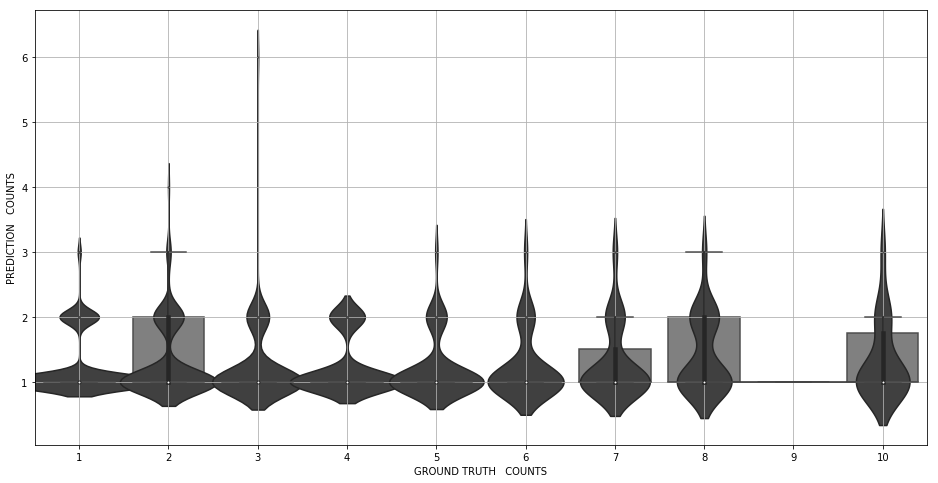

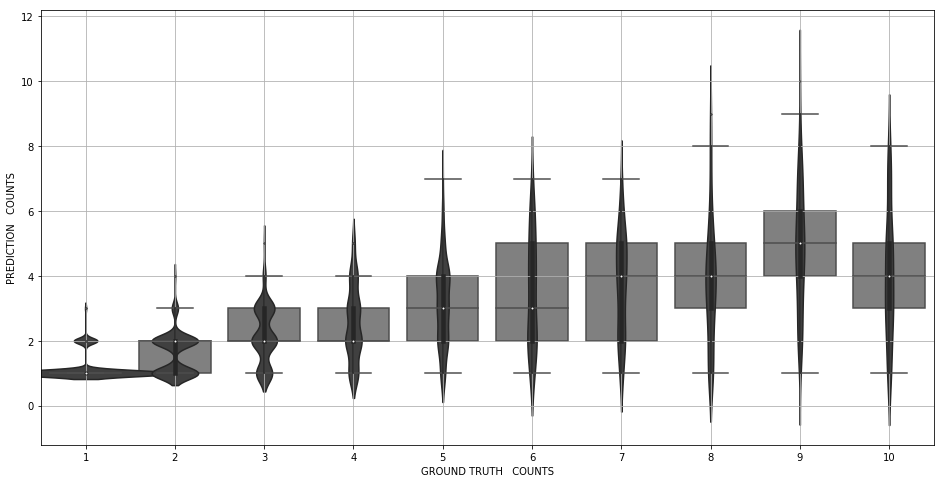

In [157]:
plt.figure()
# greater than
df_pred_gt_consolidated_count_temp = groundtruth_prediction_dataframe_gt[groundtruth_prediction_dataframe_gt['groundtruth_counts']<=10] 
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_gt_consolidated_count_temp, 
                 color="grey",
                 saturation=0.1,
#                  hue="smoker",
                 fliersize=1
                )
ax = sns.violinplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_gt_consolidated_count_temp, 
                 width=2, 
                 color='0.25'
                )

ax.set(xlabel='GROUND TRUTH   COUNTS', ylabel='PREDICTION   COUNTS')
plt.grid()
plt.savefig('./Dashboard/Exp2/Count_level_boxplot_gt_threshold_{0}_{1}.jpg'.format(round_number, species))


# less than
df_pred_lt_consolidated_count_temp = groundtruth_prediction_dataframe_lt[groundtruth_prediction_dataframe_lt['groundtruth_counts']<=10] 
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_lt_consolidated_count_temp, 
                 color="grey",
                 saturation=0.1,
#                  hue="smoker",
                 fliersize=1
                )
ax = sns.violinplot(x='groundtruth_counts', y='prediction_counts', 
                 data=df_pred_lt_consolidated_count_temp, 
                 width=2, 
                 color='0.25'
                )

ax.set(xlabel='GROUND TRUTH   COUNTS', ylabel='PREDICTION   COUNTS')
plt.grid()
plt.savefig('./Dashboard/Exp2/Count_level_boxplot_lt_threshold_{0}_{1}.jpg'.format(round_number, species))

/home/ubuntu/test_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


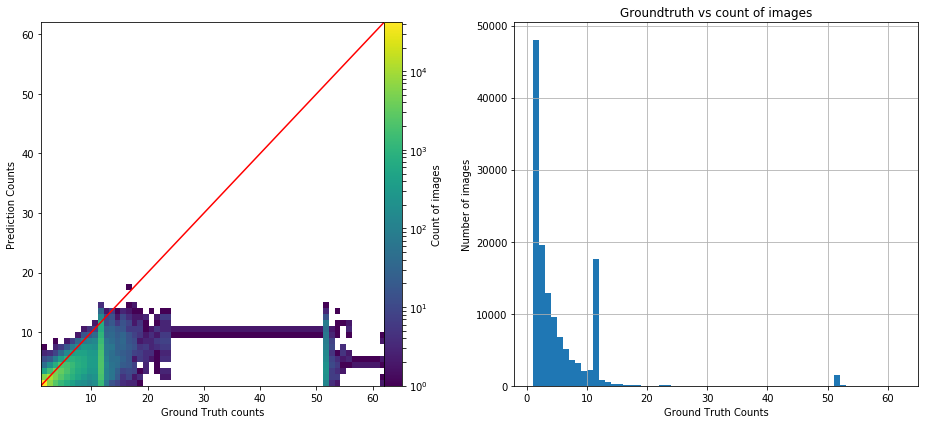

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mco
df_vis1 = df_pred_gt_consolidated_count
df_vis2 = df_pred_gt_consolidated_count
df_vis2.head()


fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), ncols=2)

x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts

limit = 65
edges = np.unique(x)# np.arange(limit+1) + 0.5
bins = edges

out1 = ax1.hist2d(x, y, bins=bins, cmap=plt.viridis(), norm=mco.LogNorm())
img1 = out1[-1]

ax1.set_xlabel('Ground Truth counts')
ax1.set_ylabel('Prediction Counts')

cbar1 = fig.colorbar(img1, ax=ax1, pad=0)
cbar1.set_label('Count of images')

ax1.plot([0, limit+1], [0, limit+1], 'r-')

# ------------------------- #
x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts
edges = np.unique(x)
bins = edges

out2 = ax2.hist(x, bins=bins, normed=False)
img2 = out2[-1]
ax2.set_title('Groundtruth vs count of images')
ax2.set_xlabel('Ground Truth Counts')
ax2.set_ylabel('Number of images')
ax2.grid()

fig.tight_layout()
fig.savefig('./Dashboard/Histogram2d_for_groundtruth_prediction_{0}.jpg'.format(round_number))

## 48x48 confusion matrix for Classification

In [18]:
def get_multi_level_confusion_matrix(df_pred_gt_consolidated):
    """ 
    This is a function that works specifially of the prediction and groundtruth consolidated dataset.
    Look at the prediction_groundtruth_consolidation.py fuction for idea on the input data format.
    """
    # df_pred_gt_consolidated to dictionary with filenames as key.
    data_dict = {}
    for r, v in df_pred_gt_consolidated.to_dict('index').items():
        if v['filename'] not in data_dict.keys():
            data_dict[v['filename']]={}
            data_dict[v['filename']]['species']=[v['species']]
            data_dict[v['filename']]['groundtruth_counts']=[v['groundtruth_counts']]
            data_dict[v['filename']]['prediction_counts']=[v['prediction_counts']]
        else:
            data_dict[v['filename']]['species'].append(v['species'])
            data_dict[v['filename']]['groundtruth_counts'].append(v['groundtruth_counts'])
            data_dict[v['filename']]['prediction_counts'].append(v['prediction_counts'])

    # Creating the layout for the confusion matrix. Initializing with 0
    cm = {}
    for species_r in set(df_pred_gt_consolidated.species):
        cm[species_r] = {}
        for species_c in set(df_pred_gt_consolidated.species):
            cm[species_r][species_c] = 0

    # Filling up the confusion matrix
    for filename, val in data_dict.items():
        j = next(j for (j, x) in enumerate(val['groundtruth_counts']) if type(x)==type('String'))
        for i in range(len(val['species'])):
            if pd.isnull(val['groundtruth_counts'][i]) + pd.isnull(val['prediction_counts'][i]) == 0:
                cm[val['species'][i]][val['species'][i]] +=1
            elif pd.isnull(val['groundtruth_counts'][i]) and ~pd.isnull(val['prediction_counts'][i]):
                cm[val['species'][i]][val['species'][j]] +=1
                
    return pd.DataFrame(cm)

In [19]:
# print(data_dict)
confusion_matrix = get_multi_level_confusion_matrix(df_pred_gt_consolidated)
confusion_matrix.to_csv('bootstrap_LowerBound50p/{0}_species_classification_confusion_matrix.csv'.format(round_number), index=True)
confusion_matrix.head()

,aardvark,aardwolf,baboon,batEaredFox,buffalo,bushbuck,caracal,cheetah,civet,dikDik,eland,elephant,gazelleGrants,gazelleThomsons,genet,giraffe,guineaFowl,hare,hartebeest,hippopotamus,honeyBadger,human,hyenaSpotted,hyenaStriped,impala,jackal,koriBustard,leopard,lionFemale,lionMale,mongoose,ostrich,otherBird,porcupine,reedbuck,rhinoceros,rodents,secretaryBird,serval,topi,vervetMonkey,warthog,waterbuck,wildcat,wildebeest,zebra,zorilla
aardvark,61,0,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
aardwolf,0,31,0,4,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
baboon,0,0,462,0,2,0,0,1,0,0,0,6,5,9,0,0,4,0,1,0,0,0,2,0,1,0,0,0,5,0,5,4,3,0,0,0,0,0,1,0,7,175,1,0,42,3,0
batEaredFox,7,0,0,31,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,5,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
buffalo,0,0,1,0,3760,0,0,0,0,2,14,682,14,30,0,0,20,0,16,11,0,1,1,0,2,0,0,0,14,2,1,15,16,0,0,0,0,0,0,12,3,191,1,0,2137,81,0


In [94]:
?ax.matshow

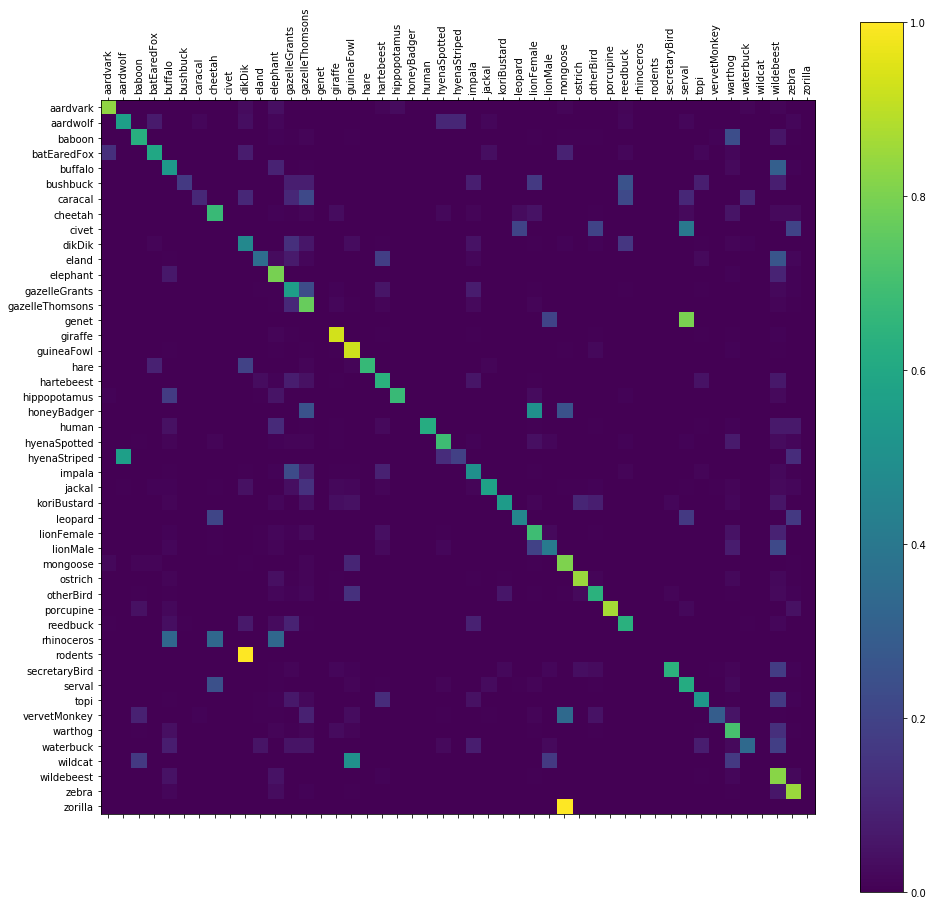

In [20]:
# Plotting the confusion matrix
features_to_normalize = list(confusion_matrix.columns)
confusion_matrix_norm = confusion_matrix.copy(deep=True)
confusion_matrix_norm['sum'] = confusion_matrix_norm.sum(axis=1)
confusion_matrix_norm[features_to_normalize] = confusion_matrix_norm[features_to_normalize].apply(lambda x:x/confusion_matrix_norm['sum'])
confusion_matrix_norm=confusion_matrix_norm.drop(columns='sum')

fig, ax = plt.subplots(figsize=(16, 16))
h = ax.matshow(confusion_matrix_norm)
ax.set_xticks(range(47))
ax.set_xticklabels(list(confusion_matrix_norm.columns), rotation='vertical')
ax.set_yticks(range(47))
ax.set_yticklabels(list(confusion_matrix_norm.columns))
fig.colorbar(h, ax=ax)
# fig = 
# plt.figure(figsize=(26, 26))
plt.show()

## Distribution of predicted box sizes

In [9]:
# Defining variabled
# round_number = 'round1_ckpt69k'
# filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/msi_test_image_list_s10-*".format(round_number))
label_map_json = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/label_map.json'
label_map = dataprep_utils.get_label_map_from_json(label_map_json)
label_map_df = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
label_map_df.columns = ['species', 'labels']
# Dimension of the raw image (overall)

In [31]:
df_pred_gt_consolidated = csc.combine_tfr_decoded_predictions(filepath_list)
df_pred_gt_consolidated = df_pred_gt_consolidated[df_pred_gt_consolidated['labels'].notnull()]
df_pred_gt_consolidated = pd.merge(left=df_pred_gt_consolidated,
                                   right=label_map_df,
                                   left_on=df_pred_gt_consolidated['labels'].astype(int),
                                   right_on=label_map_df['labels'].astype(int),
                                   how='left'
                                  )
df_pred_gt_consolidated = df_pred_gt_consolidated.drop(columns=['key_0', 'labels_y']).rename(columns={'labels_x':'labels'})
df_pred_gt_consolidated['xmax'] = df_pred_gt_consolidated['xmax']*1000
df_pred_gt_consolidated['xmin'] = df_pred_gt_consolidated['xmin']*1000
df_pred_gt_consolidated['ymax'] = df_pred_gt_consolidated['ymax']*750
df_pred_gt_consolidated['ymin'] = df_pred_gt_consolidated['ymin']*750
df_pred_gt_consolidated['width'] = df_pred_gt_consolidated['xmax'] - df_pred_gt_consolidated['xmin']
df_pred_gt_consolidated['height'] = df_pred_gt_consolidated['ymax'] - df_pred_gt_consolidated['ymin']
df_pred_gt_consolidated['area'] = round(df_pred_gt_consolidated['width']*df_pred_gt_consolidated['height'], 1)

In [32]:
label_map_df.head(2)

,species,labels
0,aardwolf,28
1,genet,44


In [33]:
df_pred_gt_consolidated.head()

,filename,labels,score,xmax,xmin,ymax,ymin,species,width,height,area
0,S10/C04/C04_R1/S10_C04_R1_IMAG4723,17.0,1.00,998.784781,2.123756,747.299820,7.466851,wildebeest,996.661024,739.832969,737362.7
1,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.00,207.094699,27.267285,498.808220,319.956422,wildebeest,179.827414,178.851798,32162.5
2,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.00,663.461566,328.254730,501.932546,318.287618,wildebeest,335.206836,183.644928,61559.0
3,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.00,720.368922,681.841433,400.078341,357.272431,wildebeest,38.527489,42.805910,1649.2
4,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,0.99,387.087137,234.325856,463.410571,335.057303,wildebeest,152.761281,128.353268,19607.4


[ 24718. 112494. 197661.]


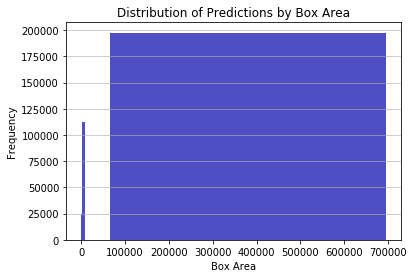

In [34]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df_pred_gt_consolidated['area'], bins=[0, 1024, 9216, 750000], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Box Area')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions by Box Area')
print(n)